# ¿Cómo puedo comparar diferentes modelos que predicen la probabilidad de impago de un préstamo?

In [1]:
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import os

from scipy import stats

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

## Introducción

Los bancos comerciales tradicionales no solían basarse en modelos estadísticos para decidir si debían emitirse préstamos personales, aunque esto está cambiando rápidamente en la actualidad. Usted es un ingeniero de machine learning que trabaja en un banco comercial moderno. Su equipo de ciencia de datos ya ha construido modelos de regresión sencillos para predecir la probabilidad de que esos préstamos sean impagados. Sin embargo, se ha dado cuenta de que muchos de estos modelos funcionan mucho peor en producción que en las pruebas.

Su tarea es construir un modelo de probabilidad de impago que se sienta cómodo poniendo en producción.

El conjunto de datos contiene los detalles de 5.000 solicitudes de préstamo que han sido emitidas previamente por su banco. Para cada préstamo, también se dispone del estado final del mismo (es decir, si el préstamo ha sido impagado):

1. El archivo **"loan_light.csv "** contiene los detalles de 5000 préstamos
2. El archivo **"loan_param.xlsx "** contiene la descripción de cada covariable

El caso se desarrollará de la siguiente manera: 1) realizará una exploración de los datos para determinar las transformaciones de las variables apropiadas; 2) ajustará algunos modelos simples; 3) aprenderá sobre la **validación cruzada** y la utilizará para seleccionar el mejor modelo simple; y finalmente 4) construirá responsablemente modelos más complejos utilizando la validación cruzada.

## Exploración de datos

Empecemos por echar un vistazo a los datos:

In [15]:
Data = pd.read_csv("data\loan_light.csv")
Data = Data.sample(frac=1)  # represental el 100 el 1 , para tomar los datos. prototipar los datos. 

In [14]:
Data.head()

,annual_inc,application_type,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,grade,inq_last_12m,installment,...,num_actv_bc_tl,pub_rec_bankruptcies,home_ownership,term,mort_acc,num_tl_90g_dpd_24m,purpose,year,loan_default,job
4222,160000.0,Individual,18867.0,0.0,0.0,5.15,1,B,1.0,382.55,...,3.0,0.0,MORTGAGE,36,4.0,0.0,major_purchase,2016,1,administrator
311,72000.0,Joint App,4565.0,0.0,0.0,16.05,10,B,1.0,96.69,...,2.0,0.0,RENT,36,0.0,0.0,car,2018,1,operator
3864,35000.0,Individual,908.0,0.0,0.0,13.55,2,D,4.0,506.07,...,1.0,0.0,RENT,36,0.0,0.0,debt_consolidation,2016,0,supervisor
371,48000.0,Individual,11090.0,0.0,6.0,17.43,10,C,5.0,247.80,...,5.0,0.0,MORTGAGE,36,3.0,0.0,debt_consolidation,2016,0,other
4387,110000.0,Individual,8593.0,0.0,2.0,17.67,3,B,1.0,409.72,...,3.0,0.0,RENT,36,1.0,1.0,debt_consolidation,2016,1,other


In [13]:
Data.keys()

Index(['annual_inc', 'application_type', 'avg_cur_bal',
       'chargeoff_within_12_mths', 'delinq_2yrs', 'dti', 'emp_length', 'grade',
       'inq_last_12m', 'installment', 'loan_amnt', 'num_actv_bc_tl',
       'pub_rec_bankruptcies', 'home_ownership', 'term', 'mort_acc',
       'num_tl_90g_dpd_24m', 'purpose', 'year', 'loan_default', 'job'],
      dtype='object')

In [18]:
df_description = pd.read_excel('data\loan_param.xlsx').dropna()
df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})

,BrowseNotesFile,Description
0,loanAmnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
1,annualInc,The self-reported annual income provided by the borrower during registration.
2,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
3,avg_cur_bal,Average current balance of all accounts
4,chargeoff_within_12_mths,Number of charge-offs within 12 months
5,delinq2Yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
6,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
7,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
8,grade,LC assigned loan grade
9,homeOwnership,"The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER."


### Ejercicio 1:

Para cada uno de los siguientes, realiza la visualización dirigida y discute tus conclusiones a partir de ella.

#### 1.1

Cree un [gráfico de barras](https://www.mathsisfun.com/data/bar-graphs.html) que muestre el número de préstamos que han sido objeto de impago y los que no lo han sido.

**Respuesta.**

In [30]:
datos=Data['loan_default'].value_counts()
Unpaid=datos[0]
paid=datos[1]
plt.bar(Unpaid)

TypeError: bar() missing 1 required positional argument: 'height'

Text(0.5, 1.0, 'loan Default')

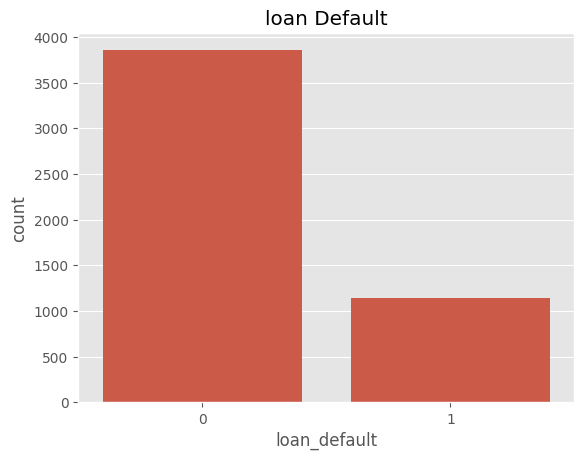

In [43]:
sns.countplot(x='loan_default',data=Data)
plt.title('loan Default')

-------

#### 1.2

Trace un [histograma](https://www.mathsisfun.com/data/histograms.html) de los ingresos anuales.

**Respuesta.**

<Axes: >

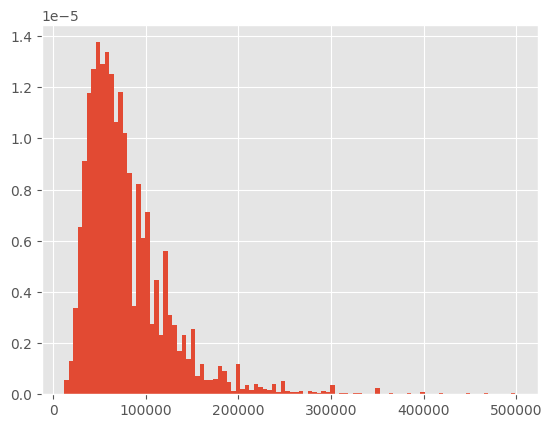

In [42]:
Data.annual_inc.hist(bins=100,density=True)

-------

Vemos que los datos están bastante sesgados. Probemos una [transformación logarítmica](https://dev.to/rokaandy/logarithmic-transformation-in-linear-regression-models-why-when-3a7c) para que los datos se distribuyan de forma más normal:

Text(0.5, 0, 'Annual Income')

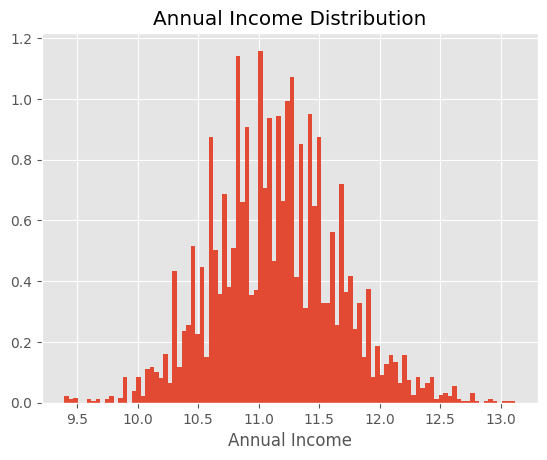

In [32]:
np.log(Data.annual_inc).hist(bins=100, density=True)
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income")

Si tiene un sesgo a la izquierda, si se hace el logaritmo con valores entre un valor en rangos mas normales, reducir , toca para llevar una distribucion normal.


#### 1.3

¿Es diferente la distribución de los ingresos anuales entre los solicitantes que incumplieron y los que no incumplieron sus préstamos?

**Respuesta.**

Text(0.5, 1.0, 'Annual Salary -- Loan Status')

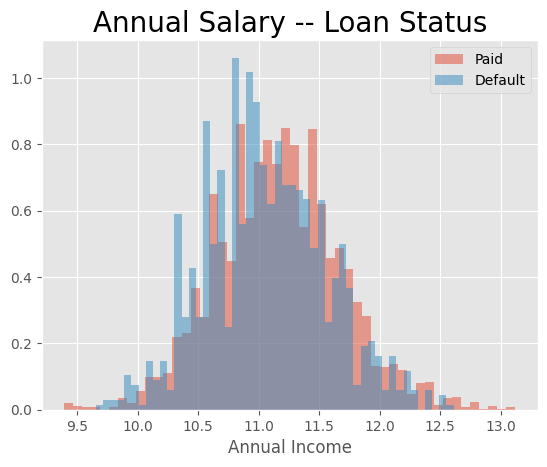

In [39]:
np.log(Data['annual_inc'][Data.loan_default == 0]).hist(bins=50, density=True, alpha=0.5, label="Paid")
np.log(Data['annual_inc'][Data.loan_default == 1]).hist(bins=50, density=True, alpha=0.5, label="Default")
plt.xlabel("Annual Income")
plt.legend()
plt.title("Annual Salary -- Loan Status", fontsize=20)

-------

#### 1.4

Explora la asociación entre los ingresos anuales y la cuota mensual.

**Respuesta.**

In [45]:
sns.jointplot(Data.installment, Data.annual_inc, hue= Data.loan_default)

TypeError: jointplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

-------

A continuación se presentan otras cifras que analizan la relación entre otras covariables numéricas y la probabilidad de impago, así como los ingresos anuales:

`emp_length`:

Text(0.5, 1.0, 'Default probability vs. emp_lenght')

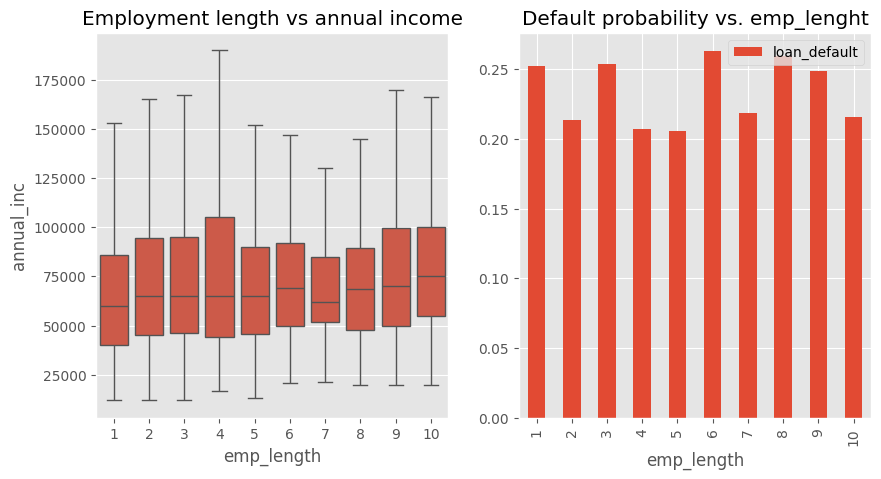

In [40]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,5), ncols=2, sharey= False)
sns.boxplot(x='emp_length', y = 'annual_inc', data = Data, showfliers=False, ax = ax1) #showfliers=False for nice display
ax1.set_title("Employment length vs annual income")
Data[["emp_length",'loan_default']].groupby("emp_length").mean().plot.bar(rot=90,ax = ax2)
plt.title("Default probability vs. emp_lenght")

`homeOwnership`:

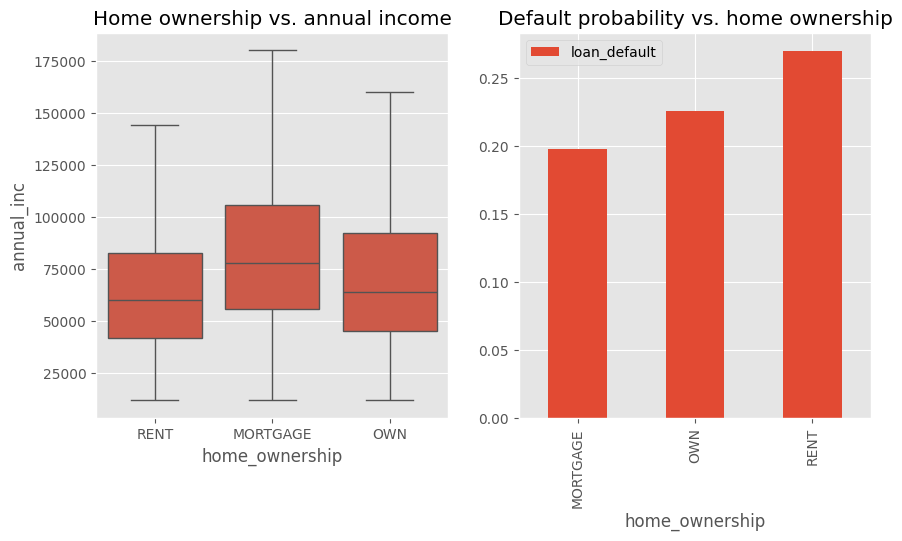

In [47]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,5), ncols=2, sharey= False)
sns.boxplot(x="home_ownership",y="annual_inc", data = Data, showfliers=False, ax = ax1) #showfliers=False for nice display
ax1.set_title("Home ownership vs. annual income")
Data[["home_ownership",'loan_default']].groupby("home_ownership").mean().plot.bar(rot=90,ax = ax2)
plt.title("Default probability vs. home ownership");

A continuación se presentan algunas cifras que muestran la relación entre diversas variables categóricas y la probabilidad de impago:

`purpose`:

In [ ]:
plt.figure(figsize= (10,5))
Data.emp_length.value_counts()
sns.countplot(x='purpose', order=Data['purpose'].value_counts().index, data = Data) 
plt.xticks(rotation=90)
plt.title("Distribution of Loan Purposes", fontsize=20);

In [ ]:
plt.figure(figsize= (10,5))
purpose_default = Data[["loan_default", "purpose"]].groupby("purpose").mean()
purpose_default = purpose_default.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=purpose_default.index[:30], 
            y=purpose_default["loan_default"][:30].values,
            orient="v")
plt.xticks(rotation=90)
plt.ylabel("Default Probability");
plt.title("Default Probability by Loan Purpose")

`job`:

In [ ]:
plt.figure(figsize= (15,5))
sns.barplot(x=Data["job"].value_counts()[:30].index.values , 
            y=100 * Data.job.value_counts()[:30].values / len(Data),
            orient="v")
plt.xticks(rotation=90)
plt.ylabel("Percentage of Population")
plt.title("Distribution of Jobs", fontsize=20);


In [ ]:
plt.figure(figsize= (20,5))

df_job_default = Data[["loan_default", "job"]].groupby("job").mean()
df_job_default = df_job_default.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=df_job_default.index[:50], 
            y=df_job_default["loan_default"][:50].values,
            orient="v")
plt.xticks(rotation=90)

plt.ylabel("Defaut Probability")
plt.title("Default Probability by Job Type", fontsize=20, verticalalignment='bottom');

### Añadir una nueva variable

La cuota anual que debe el prestatario, como fracción de sus ingresos anuales, es una métrica estándar que se utiliza para evaluar la conveniencia de conceder un préstamo. Definamos una nueva variable **"cuota_ingresos "** que codifique la cuota como fracción de los ingresos anuales y estudiemos su asociación con las demás características:

por lo genral se usa la logisctica , que da la base , y se comparo 

anadir una variable es el conocionmineto del dominio , es la relacion de dos temas 

Text(0.5, 0, 'Installment / Income')

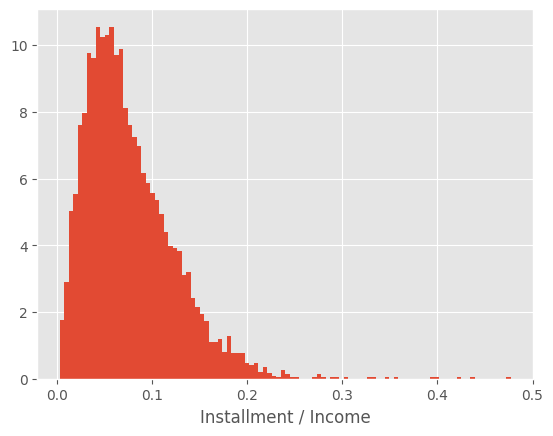

In [48]:
Data['install_income'] = 12 * Data.installment / Data.annual_inc
H = plt.hist(Data['install_income'], bins=100, density=True)
plt.xlabel(r"Installment / Income")

Para investigar fácilmente la asociación de esta variable con la probabilidad de impago, defina una nueva covariable llamada `install_income_disc` que es una versión discretizada de `install_income`:

In [ ]:
Data["install_income_disc"] = (Data.install_income*20).astype(int)/20.  #discretization
Data[["loan_default", "install_income_disc"]].groupby("install_income_disc").mean().plot.bar(rot=90)
Data = Data.drop(["install_income_disc"], axis=1)

In [ ]:
max((Data.install_income*10).astype(int)/10)

### Ejercicio 2:

Visualice la [matriz de correlación](https://www.statisticshowto.com/correlation-matrix/) en todas las características numéricas utilizando el comando `sns.heatmap()`:

**Respuesta.**

In [ ]:
#compute correlation matrix
df_correlations = Data.corr()

#mask the upper half for visualization purposes
mask = np.zeros_like(df_correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize= (10,10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlations,mask=mask,  vmax=1, vmin=-1, cmap=cmap, 
            center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

-------

## Construyendo un modelo de predicción

Empecemos por construir un [modelo de regresión logística] estándar (https://www.youtube.com/watch?v=yIYKR4sgzI8). En general, es importante y extremadamente útil crear primero modelos básicos/simples que puedan compararse con modelos más complejos más adelante.

### Ejercicio 3:

#### 3.1

Utilizando la función `LogisticRegression()` de `scikit-learn`, escriba una función llamada `fit_logistic_regression(X,y)` que ajuste una regresión logística sobre el conjunto de covariables `X` y la variable de respuesta asociada `y`.

**Respuesta.**

In [2]:
from sklearn.linear_model import LogisticRegression
def fit_logistic_regression(X, y): # y x and y son los datos que que se utilizada para entrenar y evaluar 
    # Crear una instancia del modelo de regresión logística
    model = LogisticRegression()

    # Ajustar el modelo a los datos
    model.fit(X, y)

    return model

-------

#### 3.2

Cree un [modelo de regresión logística] básico (https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc) para predecir el impago del préstamo con una sola característica: `install_income`.  Llame a este modelo `modelo1`. Utilice una división 70/30 de los datos entre el entrenamiento y la prueba.

**Respuesta.**

In [ ]:
n_total = len(Data)
n_train = int(0.7*n_total)

X, y = Data[["install_income"]], Data.loan_default
X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

model1 = fit_logistic_regression(X_train, y_train)
y_test_pred = model1.predict_proba(X_test)[:,1] 

-------

Ahora que hemos ajustado un modelo, procederemos a evaluar lo "bueno" que es. Los modelos de clasificación se juzgan de forma diferente a los modelos de regresión lineal. Una herramienta común a la que tendrá que acostumbrarse es la [matriz de confusión](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62). Además, a continuación presentaremos algunas otras métricas relacionadas con los algoritmos de clasificación. Es importante señalar que estas métricas se aplican a otros modelos de clasificación, no sólo a la regresión logística.

#### 3.3

Trace la [curva ROC](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) del `modelo1` y encuentre el área bajo la curva.

**Respuesta.**

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

fpr, tpr, _ = roc_curve(y_test, y_test_pred)  #compute FPR/TPR
auc_baseline = auc(fpr, tpr) # compute AUC

plt.plot(fpr, tpr, "b-", label="AUC(basline)={:2.2f}".format(auc_baseline))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=15)
plt.plot([0,1], [0,1], "r--")
plt.title("ROC curve -- Baseline Model");

-------

### Ejercicio 4:

#### 4.1

Considere el "modelo 1" de arriba. ¿Le gustaría que este fuera su modelo final? ¿Por qué sí o por qué no?

**Respuesta.**

-------

#### 4.2

En su lugar, pongamos todas las variables disponibles en el modelo, de modo que aprovechemos al máximo la información disponible. ¿Estarías a favor de esto o no?

**Respuesta.**

-------

En la mayoría de los casos, se trabaja con conjuntos de datos con muchas características que tienen su propia distribución. Por lo general, se dedica una gran cantidad de tiempo a la selección de características y se entrenan muchos modelos durante este tiempo. Es muy raro que simplemente se introduzcan todas las características y se ajusten una vez para obtener el modelo óptimo. 
    
En realidad, aplicaríamos la validación cruzada sobre numerosos subconjuntos de características basados en el conocimiento del dominio del conjunto de datos para ver qué conjunto de características optimiza realmente el modelo que estamos intentando crear.

## Cross-validation

La [**Validación cruzada**](https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f) es un conjunto de técnicas para evaluar la eficacia de los resultados de un modelo en un conjunto de datos fuera de la muestra, es decir, en la práctica o en la producción. Se utiliza principalmente para detectar el exceso de adaptación.

La validación cruzada funciona de la siguiente manera: se dividen los datos disponibles en $k$ conjuntos, o **folds (pliegues)**. Se utilizarán $k - 1$ de estos pliegues para entrenar el modelo, mientras que el pliegue retenido se utilizará como conjunto de prueba en el que se evalúa el modelo. Para la estabilidad computacional, este procedimiento se suele dividir muchas veces, de forma que cada pliegue tenga la oportunidad de servir como conjunto de prueba. Para cada repetición, se calcula una métrica de rendimiento de la predicción (por ejemplo, AUC) en el conjunto de prueba. A continuación, se presenta la media de estas métricas, así como su desviación estándar. 

No existe una ciencia exacta para elegir un $k$ adecuado para su conjunto de datos. Depende del tipo de datos que se utilice y de su tamaño. Cuanto más grande sea $k$, más iteraciones se realizan, lo que reduce la posibilidad de tener "mala suerte"; sin embargo, realizar más iteraciones puede ser costoso en algunos casos. Además, es importante asegurarse de que, independientemente de la cantidad de $k$ que se elija, el conjunto de validación sea lo suficientemente grande como para que tenga sentido. Si tiene un conjunto de datos de 100 puntos y elige un $k$ de 20, entonces el conjunto de validación será sólo de 5 puntos. Es probable que algunas iteraciones tengan un mal rendimiento simplemente porque el conjunto de validación es demasiado pequeño y potencialmente demasiado diferente del conjunto de entrenamiento.

Aquí se muestra un ejemplo de validación cruzada de 5 veces:

![](cv_fig.png)

Hagamos esto con código. El siguiente código muestra los 5 pliegues diferentes utilizados en un enfoque estándar de validación cruzada de 5 pliegues. Para ello, utiliza la función `StratifiedKFold()` de `scikit-learn`:

In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
for k, (train_index, test_index) in enumerate( skf.split(X, y) ):
    plt.plot(train_index, [k+1 for _ in train_index], ".")
plt.ylim(0,6)
plt.ylabel("FOLD")
plt.title("CROSS VALIDATION FOLDS")

El siguiente código define una función `compute_AUC(X, y, train_index, test_index)` que calcula el AUC de un modelo entrenado en "train_index" y probado en "test_index".

In [ ]:
def compute_AUC(X, y, train_index, test_index):
    """
    feature/output: X, y
    dataset split: train_index, test_index
    """
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    clf = fit_logistic_regression(X_train, y_train)
    default_proba_test = clf.predict_proba(X_test)[:,1]  
    fpr, tpr, _ = roc_curve(y_test, default_proba_test)
    auc_score = auc(fpr, tpr)
    return auc_score, fpr, tpr

### Ejercicio 5:

Con la ayuda de la función `compute_AUC` definida anteriormente, escriba una función `cross_validation_AUC(X,y,nfold)` que realice una validación cruzada de 10 pliegues y devuelva una lista que contenga el área bajo la curva para cada pliegue de la validación cruzada.

**Respuesta.**

-------

Ahora estimaremos y compararemos, mediante un análisis de validación cruzada, el rendimiento de todos los "modelos simples" que sólo utilizan una característica numérica como entrada. Como se ha comentado en la sección EDA, utilizaremos la transformación logarítmica para las variables "ingresos anuales", "importe del préstamo" y "valor medio":

In [ ]:
# let us extract only the numerical (i.e non-categorical) features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
Data_numerics = Data.select_dtypes(include=numerics)
Data_numerics = Data_numerics.drop(["installment", "year"], axis=1)

# Using a log scale when appropriate
Data_numerics["annual_inc"] = np.log10(Data_numerics["annual_inc"])
Data_numerics["loan_amnt"] = np.log10(Data_numerics["loan_amnt"])
Data_numerics["avg_cur_bal"] = np.log10(1.+Data_numerics["avg_cur_bal"])

Calculemos las estimaciones de validación cruzada del AUC para cada modelo de característica única:

In [ ]:
model_perf = pd.DataFrame({}) #this data-frame will contain the AUC estimates
for key in Data_numerics.keys():
    if key == "loan_default": continue
    X_full, y_full = Data_numerics[[key]], Data_numerics.loan_default
    auc_list = cross_validation_AUC(X_full, y_full, nfold=10)
    model_perf["SIMPLE:" + key] = auc_list

### Ejercicio 6:

Construya un [boxplot](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51) que muestre la distribución de las puntuaciones de validación cruzada de cada variable (recuerde que cada variable tiene 10 puntuaciones totales). ¿Qué característica tiene el mayor/menor poder predictivo?

**Respuesta.**

In [ ]:
def plot_boxplot_ordered(df_model):
    """
    display a list of boxplot, ordered by the media values
    """
    df = df_model[df_model.median().sort_values().index]
    sns.boxplot(x="variable", y="value", data=pd.melt(df), showfliers=False)
    plt.xticks(rotation=90)
    
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC")

-------

### Ejercicio 7:

Considere el modelo que consiste en utilizar *todas* las características numéricas (y ninguna de las características categóricas). Realice un análisis de validación cruzada de 10 veces para determinar si este modelo tiene un mejor rendimiento predictivo que el mejor modelo de una sola característica. Vuelva a utilizar el método de boxplot como hicimos en el Ejercicio 7.

**Respuesta.**

-------

## Incorporación de variables categóricas

El grado de un préstamo (es decir, la característica de grado de préstamo asignada por la LC) no se ha utilizado hasta ahora. A continuación se muestra la distribución de la característica de grado categórico:

In [ ]:
Data.emp_length.value_counts()
sns.countplot(x='grade', data = Data) 
plt.xticks(rotation=90)

### Ejercicio 8:

#### 8.1

Utilice `pandas.get_dummies()` para transformar esto en su versión codificada 'one-hot.

**Respuesta.**

-------

#### 8.2

Añada esta característica al modelo totalmente numérico de antes e investigue si esto conduce a un aumento significativo de la precisión predictiva.

**Respuesta.**

-------

### Ejercicio 9

Investigue si la variable categórica `job` aporta algún valor predictivo cuando se añade al mejor modelo actual. De nuevo, es posible que desee utilizar un esquema de codificación one-hot.

**Respuesta.**

In [ ]:
plt.figure(figsize= (20,5))

df_job_default = Data[["loan_default", "job"]].groupby("job").mean()
df_job_default = df_job_default.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=df_job_default.index[:50], 
            y=df_job_default["loan_default"][:50].values,
            orient="v")
plt.xticks(rotation=90)

plt.ylabel("Defaut Probability")
plt.title("Default Rate per Employment Type", fontsize=20, verticalalignment='bottom')

In [ ]:
job_categ = pd.get_dummies(Data['job'], prefix = "job", drop_first=True)

X_grade_job = pd.concat([X_grade,job_categ],axis=1) 


X_grade_job.keys()


auc_list = cross_validation_AUC(X_grade_job, y_full)
model_perf["ALL_NUMERICAL_WITH_GRADE_JOB"] = auc_list

plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC")

-------

## Conclusiones

En este caso, primero exploramos el conjunto de datos de préstamos y encontramos las asociaciones de una sola variable entre las características disponibles y la tasa de impago. También descubrimos qué características requerían transformaciones (por ejemplo, la transformación logarítmica).

Una vez que empezamos a construir modelos, comenzamos con enfoques de regresión logística muy sencillos; estos modelos de referencia eran útiles para evaluar rápidamente el poder predictivo de cada variable individual. A continuación, empleamos enfoques de validación cruzada para construir modelos más complejos, a menudo explotando las interacciones entre las diferentes características. Dado que el conjunto de datos de préstamos contiene un gran número de covariables, el uso de la validación cruzada resultó ser crucial para evitar el exceso de ajuste, elegir el número correcto de características y, en última instancia, elegir un modelo adecuado que equilibre la complejidad con la precisión.

La validación cruzada es una técnica robusta y flexible para evaluar el rendimiento predictivo de los modelos estadísticos. Es especialmente útil en entornos de big data en los que el número de características es grande en comparación con el número de observaciones. Cuando se utiliza adecuadamente, la validación cruzada es un método poderoso para elegir un modelo con la complejidad correcta y el mejor rendimiento predictivo. Recuerde que la regresión logística es sólo uno de los muchos algoritmos de clasificación y que los principios en los que se basa la validación cruzada no se limitan sólo a este caso. De hecho, recomendamos encarecidamente utilizar la validación cruzada también para sus modelos de regresión lineal para evitar el sobreajuste.